# Plotting Notebook

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import os, sys, glob
import pickle
import math
import itertools
import warnings
import json
import numpy as np
from typing import Dict, List
from rich.pretty import pprint
from rich.console import Console
from rich.table import Table
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import hist
from hist import Hist
import mplhep as hep
from tabulate import tabulate
import scipy
import uproot
import ROOT
import iminuit
import iminuit.cost
%aimport plot_utils
%aimport plot_utils_extras
%aimport fill_utils

warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'figure.max_open_warning': 0})
matplotlib.rcParams['figure.facecolor'] = 'white'
plt.style.use(hep.style.CMS)

Welcome to JupyROOT 6.26/04


In [4]:
print("The following output directories are available:")
!ls | grep output_histograms

The following output directories are available:
CR_cb_34mu_output_histograms
CR_cb_combine_output_histograms
CR_cb_output_histograms
CR_cb_postDYstudy_output_histograms
CR_light_postDYstudy_output_histograms
CR_prompt_34mu_leading_output_histograms
CR_prompt_34mu_output_histograms
CR_prompt_combine_output_histograms
CR_prompt_dimuon_output_histograms
CR_prompt_dystudy_output_histograms
CR_prompt_leading_output_histograms
CR_prompt_output_histograms
CR_prompt_postDYstudy_output_histograms
DYstudy_2_output_histograms
DYstudy_3_output_histograms
DYstudy_4_output_histograms
DYstudy_5_output_histograms
DYstudy_output_histograms
DYstudy_trigger_match_double_output_histograms
DYstudy_trigger_match_triple_output_histograms
DYstudy_trigger_one_path_output_histograms
nbjet_comparison_output_histograms
SR_combine_output_histograms
SR_postDYstudy_output_histograms
temp_output_histograms


## Notebook Parameters
The following couple cells define the input and output directories, and load in the desired .pkl files into the `plots` nested dictionary.<br>
`output_label`: _str_, saves plots as `<output_label>+<plot_name>.<file_ext>`.<br>
`file_ext`: _str_, see above.<br>

In [5]:
# parameters
output_label = './output_plots/'
file_ext = '.png'

The `plots` dictionary is used to store all the plots imported from the pickle files. Dimensions: (sample) x (plot label) <br>
The `loader` function in `plot_utils.py` automatically merges all the QCD HT and QCD pT bins into one sample ('QCD_HT' and 'QCD_Pt'), applies the lumis, and excludes some of the low QCD bins.<br>

In [6]:
# create output dir
if not os.path.isdir(output_label): 
    print("Creating", output_label)
    os.mkdir(output_label)

# This part is meant to be flxeible, depending on what you want to import
# dimensions of plots: (sample) x (plot label)
# N.B.: lumis are applied through loader()

# input .pkl files
plotDir = './CR_prompt_combine_output_histograms/'
infile_names = glob.glob(plotDir+'*.pkl')

# generate list of files that you want to merge histograms for
offline_files_SUEP = [
    f for f in infile_names if ("SUEP" in f) and ("histograms.pkl" in f)
]
offline_files_normalized = [
    f for f in infile_names if ("normalized.pkl" in f)
]
offline_files_other = [
    f for f in infile_names if ("pythia8" in f) and ("histograms.pkl" in f)
]
offline_files = offline_files_normalized + offline_files_other
pprint(offline_files)

data_files = [
    f for f in infile_names if ("DoubleMuon" in f) and ("histograms.pkl" in f)
]
pprint(data_files)

other_bkg_names = {
    "DY0JetsToLL": "DY0JetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8",
    "DYJetsToLL_NLO": "DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8",
    "DYLowMass_NLO": "DYJetsToLL_M-10to50_TuneCP5_13TeV-amcatnloFXFX-pythia8+"
                     "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM",
    "DYLowMass_LO": "DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8+"
                    "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM",
    "TTJets": "TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8+"
              "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM",
    "ttZJets": "ttZJets_TuneCP5_13TeV_madgraphMLM_pythia8+"
               "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM",
    "WWZ_4F": "WWZ_4F_TuneCP5_13TeV-amcatnlo-pythia8+"
              "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1_ext1-v2+MINIAODSIM",
    "ZZTo4L": "ZZTo4L_TuneCP5_13TeV_powheg_pythia8+"
              "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM",
    "ZZZ": "ZZZ_TuneCP5_13TeV-amcatnlo-pythia8+"
           "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1_ext1-v2+MINIAODSIM",
    "WJets_inclusive": "WJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-pythia8+"
                 "RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM",
    "ST_tW": "ST_tW_Dilept_5f_DR_TuneCP5_13TeV-amcatnlo-pythia8+"
             "RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM"
}

# merge the histograms, apply lumis, exclude low HT bins
plots_SUEP_2018 = plot_utils.loader(offline_files_SUEP, year=2018, custom_lumi=573.120134)
plots_2018 = plot_utils.loader(offline_files, year=2018, custom_lumi=573.120134)
plots_data = plot_utils.loader(data_files, year=2018, is_data=True)

# put everything in one dictionary, apply lumi for SUEPs
plots = {}
for key in plots_SUEP_2018.keys(): 
    plots[key+"_2018"] = fill_utils.apply_normalization(
        plots_SUEP_2018[key], 
        fill_utils.getXSection(key+'+RunIIAutumn18-private+MINIAODSIM', '2018', SUEP=True)
    )
for key in plots_2018.keys():
    is_binned = False
    binned_samples = [
        "QCD_Pt",
        "WJetsToLNu_HT",
        "WZTo",
        "WZ_all",
        "WWTo",
        "WW_all",
        "ST_t-channel",
        "JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8",
        "DYNJetsToLL",
    ]
    for binned_sample in binned_samples:
        if binned_sample in key:
            is_binned = True
    if is_binned and ('normalized' not in key) and ('cutflow' in key):
        continue
    if is_binned or ('bkg' in key):
        plots[key+"_2018"] = plots_2018[key]
    else:
        plots[key+"_2018"] = fill_utils.apply_normalization(
            plots_2018[key], 
            fill_utils.getXSection(other_bkg_names[key], '2018', SUEP=False)
        )

for key in plots_data.keys(): 
    plots[key+"_2018"] = plots_data[key]

# Combine DYJetsToLL_NLO with DYLowMass_NLO
dy_nlo_all = {}
for plt_i in plots["DYLowMass_NLO_2018"].keys():
    dy_nlo_all[plt_i] = (
        plots["DYLowMass_NLO_2018"][plt_i] + plots["DYJetsToLL_NLO_2018"][plt_i]
    )
plots["DY_NLO_all_2018"] = dy_nlo_all    

# Combine DYNJetsToLL with DYLowMass_LO
dy_combined = {}
for plt_i in plots['DYLowMass_LO_2018'].keys():
    dy_combined[plt_i] = plots['DYLowMass_LO_2018'][plt_i] + plots['DYNJetsToLL_2018'][plt_i]
plots['DYCombined_2018'] = dy_combined

# Combine ZZZ with WWZ
vvv_combined = {}
for plt_i in plots['WWZ_4F_2018'].keys():
    vvv_combined[plt_i] = plots['WWZ_4F_2018'][plt_i] + plots['ZZZ_2018'][plt_i]
plots['VVV_2018'] = vvv_combined

# Combine ZZ, WZ, and WW
vv_combined = {}
for plt_i in plots['WZ_all_2018'].keys():
    vv_combined[plt_i] = plots['WW_all_2018'][plt_i] + plots['WZ_all_2018'][plt_i] + plots['ZZTo4L_2018'][plt_i]
plots['VV_2018'] = vv_combined

# Combine ST
st_combined = {}
for plt_i in plots['ST_t-channel_2018'].keys():
    st_combined[plt_i] = plots['ST_t-channel_2018'][plt_i] + plots['ST_tW_2018'][plt_i]
plots['ST_2018'] = st_combined

# Combine WJetsHT and WJets_inclusive
wjets_combined = {}
for plt_i in plots['WJetsToLNu_HT_2018'].keys():
    wjets_combined[plt_i] = plots['WJetsToLNu_HT_2018'][plt_i] + plots['WJets_inclusive_2018'][plt_i]
plots['WJets_all_2018'] = wjets_combined

# Normalize QCD MuEnriched if it exists
if "QCD_Pt_MuEnriched_2018" in plots.keys():
    for plot in plots["QCD_Pt_MuEnriched_2018"].keys():
        plots["QCD_Pt_MuEnriched_2018"][plot] = plots["QCD_Pt_MuEnriched_2018"][plot] * 0.7

[
│   './CR_prompt_combine_output_histograms/DY1JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer19UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './CR_prompt_combine_output_histograms/DY2JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer19UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './CR_prompt_combine_output_histograms/DY3JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer19UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './CR_prompt_combine_output_histograms/DY4JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer19UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './CR_prompt_combine_output_histograms/QCD_Pt-1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './CR_prompt_combine_output_histograms/QCD_Pt-120To170_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './CR_prompt_combine_output_histograms/QCD_Pt-15To20_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './CR_prompt_combine_output_histograms/QCD_Pt-170To300_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './CR_prompt_combine_output_histograms/QCD_Pt-20To30_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './CR_prompt_combine_output_histograms/QCD_Pt-300To470_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './CR_prompt_combine_output_histograms/QCD_Pt-30To50_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './CR_prompt_combine_output_histograms/QCD_Pt-470To600_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './CR_prompt_combine_output_histograms/QCD_Pt-50To80_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './CR_prompt_combine_output_histograms/QCD_Pt-600To800_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './CR_prompt_combine_output_histograms/QCD_Pt-800To1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './CR_prompt_combine_output_histograms/QCD_Pt-80To120_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './CR_prompt_combine_output_histograms/QCD_Pt_1000to1400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './CR_prompt_combine_output_histograms/QCD_Pt_120to170_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM_histograms_normalized.pkl',
│   './CR_prompt_combine_output_histograms/QCD_Pt_1400to1800_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './CR_prompt_combine_output_histograms/QCD_Pt_15to30_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized.pkl',
│   './CR_prompt_combine_output_histograms/QCD_Pt_170to300_TuneCP5_1

[
│   './CR_prompt_combine_output_histograms/DoubleMuon+Run2018A-UL2018_MiniAODv2-v1+MINIAOD_histograms.pkl'
]

These are all the samples loaded.

In [186]:
bkgs = [
    'VVV_2018',
    'ttZJets_2018',
    'WJets_all_2018',
    'ST_2018',
    'VV_2018',
    'TTJets_2018',
    'DYLowMass_NLO_2018',
    'DYJetsToLL_NLO_2018',
    'QCD_Pt_MuEnriched_2018',
]
plots_sources = plot_utils_extras.split_bkgs(plots=plots, bkg_list=bkgs)
plots.update(plots_sources)
plots_sources_per_process = plot_utils_extras.split_bkgs_per_process(plots=plots, bkg_list=bkgs)

In [187]:
processes = [
    'VVV_2018',
    'ttZJets_2018',
    'WJets_all_2018',
    'ST_2018',
    'VV_2018',
    'TTJets_2018',
    'DYLowMass_NLO_2018',
    'DYJetsToLL_NLO_2018',
    'QCD_Pt_MuEnriched_2018',
]
sources = [
    "c/b",
    "light/other",
    "prompt",
]
plots_processes_per_source = plot_utils_extras.invert_dict(plots_sources_per_process, processes, sources)

In [188]:
keys = list(plots.keys())
pprint(keys)

[
│   'SUEP-m125-darkPho_2018',
│   'SUEP-m125-darkPhoHad_2018',
│   'SUEP-m400-darkPho_2018',
│   'SUEP-m400-darkPhoHad_2018',
│   'SUEP-m750-darkPho_2018',
│   'SUEP-m750-darkPhoHad_2018',
│   'SUEP-m1000-darkPho_2018',
│   'SUEP-m1000-darkPhoHad_2018',
│   'DY1JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer19UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'bkg_2018',
│   'DYNJetsToLL_2018',
│   'DY2JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer19UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'DY3JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer19UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'DY4JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer19UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt-1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt_MuEnriched_2018',
│   'QCD_Pt-120To170_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt-15To20_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt-170To300_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt-20To30_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt-300To470_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt-30To50_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt-470To600_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt-50To80_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt-600To800_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt-800To1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt-80To120_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt_1000to1400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_2018',
│   'QCD_Pt_120to170_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_1400to1800_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_15to30_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_170to300_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_1800to2400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_2400to3200_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_30

In [189]:
for key in plots['QCD_Pt_2018'].keys():
    pprint(f"{key = }")

"key = 'ht'"

"key = 'muon_pt'"

"key = 'muon_eta'"

## Combine histograms

In the following section we will combine (i.e., arrange horizontally) three histograms: 
 - muon_pt, 
 - muon_eta, 
 - muon_phi

In [211]:
processes = [
    #'DoubleMuon+Run2018A-UL2018_MiniAODv2-v1+MINIAOD_histograms_2018',
    'VVV_2018',
    'ttZJets_2018',
    'WJets_all_2018',
    'ST_2018',
    'VV_2018',
    'TTJets_2018',
    'DY_NLO_all_2018',
    'QCD_Pt_MuEnriched_2018',
]
names = [
    'ht',
    'muon_pt',
    'muon_eta',
]
with uproot.recreate('test.root') as file:
    for p in processes:
        for n in names:
            file[f"{p}/{n}"] = plots[p][n][:, 2]

In [215]:
processes = [
    #'DoubleMuon+Run2018A-UL2018_MiniAODv2-v1+MINIAOD_histograms_2018',
    'VVV_2018',
    'ttZJets_2018',
    'WJets_all_2018',
    'ST_2018',
    'VV_2018',
    'TTJets_2018',
    'DY_NLO_all_2018',
    'QCD_Pt_MuEnriched_2018',
]
names = [
    'ht',
    'muon_pt',
    'muon_eta',
]
h_new = {}
with uproot.open('test.root') as file:
    for n in names:
        if n not in h_new.keys():
            h_new[n] = None
        for p in processes:
            if h_new[n] is None:
                h_new[n] = file[f"{p}/{n}"].to_pyroot()
            else:
                h_new[n].Add(file[f"{p}/{n}"].to_pyroot())

In [216]:
def combine_histograms(h_list):
    n_bins_tot = sum([h.GetNbinsX() for h in h_list])
    c = ROOT.TCanvas('c', 'c', 1200, 600)
    c.Draw()
    h_total = ROOT.TH1D('h_total', 'h_total', n_bins_tot, 0, n_bins_tot)
    h_total.GetXaxis().SetTitle("bin number")
    offset = 0
    for i, h in enumerate(h_list):
        for j_bin in range(h.GetNbinsX()):
            h_total.SetBinContent(offset+j_bin+1, h.GetBinContent(j_bin+1))
            h_total.SetBinError(offset+j_bin+1, h.GetBinError(j_bin+1))
        offset += h.GetNbinsX()
    h_total.Draw()
    h_total.GetYaxis().SetRangeUser(1e-1, 1e4)
    c.Update()
    c.SetLogy()
    return c, h_total

def combine_histograms_plotting(h_list):
    n_bins_tot = sum([h.GetNbinsX() for h in h_list])
    c = ROOT.TCanvas('c', 'c', 1200, 600)
    c.Draw()
    h_total = ROOT.TH1D('h_total', 'h_total', n_bins_tot, 0, n_bins_tot)
    h_total.GetXaxis().SetBit(ROOT.TAxis.kLabelsHori)
    h_total.GetXaxis().SetLabelSize(0)
    offset = 0
    for i, h in enumerate(h_list):
        for j_bin in range(h.GetNbinsX()):
            h_total.SetBinContent(offset+j_bin+1, h.GetBinContent(j_bin+1))
            h_total.SetBinError(offset+j_bin+1, h.GetBinError(j_bin+1))
        offset += h.GetNbinsX()
    h_total.Draw()
    h_total.GetYaxis().SetRangeUser(1e-5, 1e5)
    h_total.GetXaxis().SetTickSize(0)
    min_log = ROOT.TMath.Log10(h_total.GetMinimum())
    label_y_pos = ROOT.TMath.Power(10, min_log - 0.05 * (ROOT.TMath.Log10(h_total.GetMaximum()) - min_log))
    l = ROOT.TLine()
    text = ROOT.TText()
    text.SetTextAlign(22)
    text.SetTextSize(0.033)
    bins_with_labels = lambda n : [n*0.1, n/2, n*0.9]
    offset = 0
    for i, h in enumerate(h_list):
        for j_bin in range(h.GetNbinsX()):
            l.DrawLine(offset+j_bin, 1e-5, offset+j_bin, 1.5*1e-5)
            if j_bin in bins_with_labels(h.GetNbinsX()):
                l.DrawLine(offset+j_bin, 1e-5, offset+j_bin, 4*1e-5)
                text.DrawText(offset+j_bin, label_y_pos, f"{h.GetBinLowEdge(j_bin+1):.1f}")
        text.DrawText(offset+h.GetNbinsX()/2, 0.3*label_y_pos, f"{h.GetXaxis().GetTitle()}")
        offset += h.GetNbinsX()
        l.DrawLine(offset, 1e-5, offset, 1e5)
    c.Update()
    c.SetLogy()
    return c, h_total

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h_total (Potential memory leak).


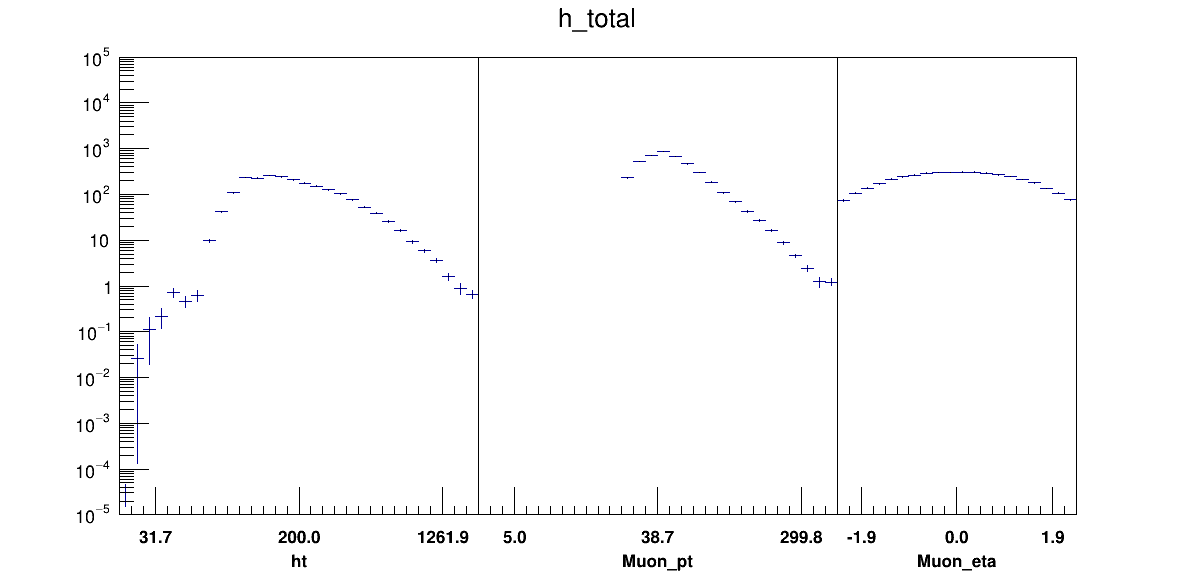

In [217]:
c, h_total = combine_histograms_plotting([h_new[h] for h in h_new.keys()])
ROOT.gStyle.SetOptStat(0)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h_total (Potential memory leak).


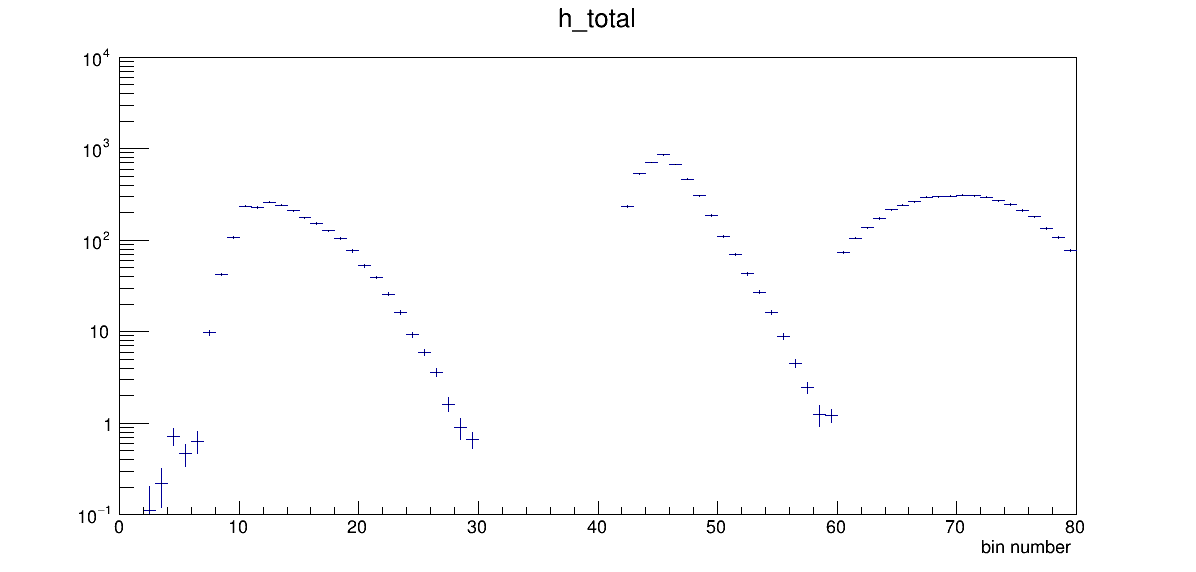

In [218]:
c, h_total = combine_histograms([h_new[h] for h in h_new.keys()])
ROOT.gStyle.SetOptStat(0)

## Fit

First, put the values of the hist bins into arrays:

In [266]:
data = 'DoubleMuon+Run2018A-UL2018_MiniAODv2-v1+MINIAOD_histograms_2018'
processes = [
    #'VVV_2018',
    #'ttZJets_2018',
    #'WJets_all_2018',
    #'ST_2018',
    #'VV_2018',
    'TTJets_2018',
    'DY_NLO_all_2018',
    'QCD_Pt_MuEnriched_2018',
]
hist_names = [
    'ht',
    'muon_pt',
    'muon_eta',
]
xe = None # array of bin edges
n = None # array of data counts
t = None # array of arrays of MC counts
vt = None # array of arrays of MC variances

# Take care of the data
for hn in hist_names:
    if n is None:
        n = plots[data][hn][:, 2].values()
    else:
        n = np.append(n, plots[data][hn][:, 2].values())
xe = np.arange(len(n)+1)
for p in processes:
    ti = None
    vti = None
    for hn in hist_names:
        if ti is None:
            ti = plots[p][hn][:, 2].values()
            vti = plots[p][hn][:, 2].variances()
        else:
            ti = np.append(ti, plots[p][hn][:, 2].values())
            vti = np.append(vti, plots[p][hn][:, 2].variances())
    if t is None:
        t = np.array([ti])
        vt = np.array([vti])
    else:
        t = np.array([*t, ti])
        vt = np.array([*vt, vti])

In [267]:
print("Data array:")
n

Data array:


array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   8.,  30.,  88., 221.,
       191., 237., 218., 165., 177., 158., 107.,  78.,  65.,  45.,  34.,
        22.,  13.,  12.,   9.,   4.,   0.,   1.,   2.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 208., 477.,
       625., 768., 623., 389., 290., 159.,  74.,  67.,  39.,  24.,   9.,
         8.,   7.,   3.,   0.,   0.,  59.,  87., 128., 160., 187., 218.,
       254., 268., 268., 267., 310., 283., 258., 198., 201., 177., 160.,
       137.,  77.,  73.])

In [268]:
np.set_printoptions(suppress=True, precision=1)
print("MC values:")
print(t)
print("MC variances:")
print(vt)

MC values:
[[  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.1   0.3   1.1
    3.1   8.1  17.9  32.5  45.3  49.8  44.9  36.2  26.7  19.2  13.7   8.1
    4.2   2.9   1.6   0.8   0.4   0.2   0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.   31.5  63.5  73.8  77.1  79.   74.4
   65.9  54.2  42.1  29.4  18.4  11.8   6.6   3.3   1.8   0.9   0.3   0.3
    7.9  12.6  18.3  23.8  30.4  36.8  40.2  46.9  49.3  50.   49.3  49.7
   47.6  40.5  37.7  31.2  24.7  17.1  12.9   7.4]
 [  0.    0.    0.1   0.2   0.7   0.5   0.6   9.5  41.1 105.6 231.  217.2
  250.4 226.6 183.2 136.1  98.3  70.9  53.7  34.9  22.3  17.5   9.9   6.8
    4.2   2.5   1.7   0.6   0.4   0.4   0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.  188.2 445.3 615.6 762.1 575.4 373.5
  225.8 121.7  59.6  35.2  20.7  12.9   8.2   4.6   2.1   1.3   0.8   0.7
   63.3  89.2 113.2 142.1 175.5 196.9 213.4 238.1 240.1 243.9 249.1 248.4
  236.8 215.7 197.4 172.4 150.  112.7  89.7  65.9]
 

In [269]:
np.set_printoptions(suppress=True, precision=0)
print("Sum of MC (per bin):")
print(np.sum(t, axis=0))
print("Sum of MC (per process):")
print(np.sum(t, axis=1))
print(processes)

Sum of MC (per bin):
[  0.   0.   0.   0.   1.   0.   1.  10.  41. 106. 231. 222. 253. 235.
 201. 169. 145. 121.  99.  72.  50.  37.  24.  15.   8.   5.   3.   1.
   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 224. 514. 691. 840. 656. 449. 292. 177. 102.  65.  39.  25.  15.   8.
   4.   2.   1.   1.  71. 102. 132. 166. 208. 235. 254. 285. 290. 294.
 299. 298. 285. 261. 239. 204. 175. 130. 103.  75.]
Sum of MC (per process):
[1585. 8635.   44.]
['TTJets_2018', 'DY_NLO_all_2018', 'QCD_Pt_MuEnriched_2018']


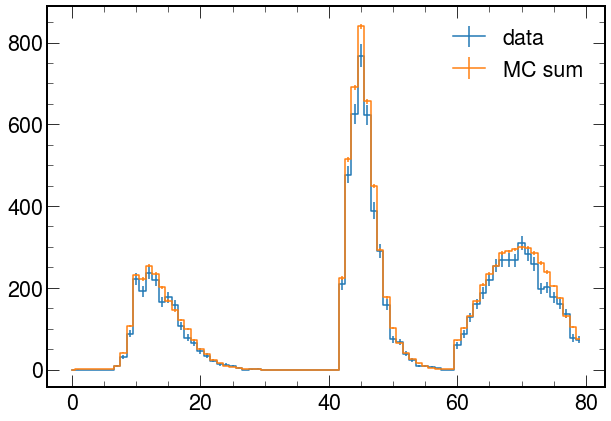

In [270]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
x_vals = range(len(n))
ax.errorbar(x_vals, n, yerr=np.sqrt(n), drawstyle="steps-mid", label="data")
ax.errorbar(x_vals, np.sum(t, axis=0), yerr=np.sqrt(np.sum(vt, axis=0)), drawstyle="steps-mid", label="MC sum")
plt.legend();

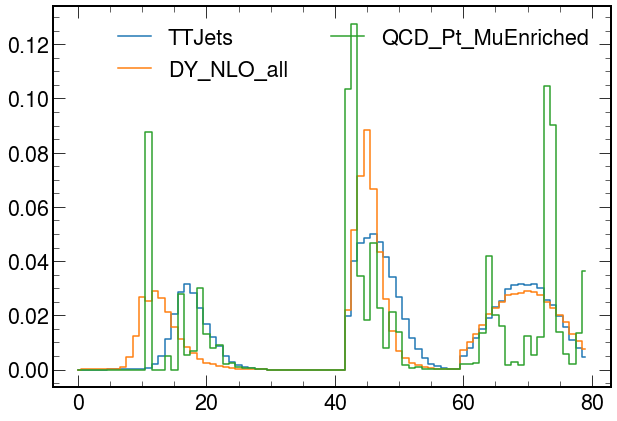

In [271]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
x_vals = range(len(n))
#ax.errorbar(x_vals, n/np.sum(n), drawstyle="steps-mid", label="data")
for i, ti in enumerate(t):
    ax.errorbar(x_vals, ti/np.sum(ti), drawstyle="steps-mid", label=f"{processes[i][:-5]}")
plt.legend(ncol=2);

Now perform the fit using the Barlow-Beeston-lite (named 'jsc' for J.S. Conway)

In [273]:
c = iminuit.cost.Template(n, xe, t, method="jsc", verbose=0) # Conway
start = np.sum(t, axis=1) # Use the MC predicted yields as starting point
m = iminuit.Minuit(c, *start)
m.limits = (0, None)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 36.87 (χ²/ndof = 0.5)      │              Nfcn = 90               │
│ EDM = 3.82e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  1.57e3   │  0.18e3   │            │            │    0    │         │       │
│ 1 │ x1   │  7.87e3   │  0.21e3   │            │            │    0    │         │       │
│ 2 │ x2   │     0     │     8     │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────┐
│    │       x0       x1       x2 │
├────┼────────────────────────────┤
│ x0 │ 3.42e+04 -0.031e6    -0.08 │
│ x1 │ -0.031e6 4.59e+04    -0.12 │
│ x2 │    -0.08    -0.12    0.214 │
└────┴────────────────────────────┘

The fit parameters:

In [274]:
for i in range(len(t)): print(f"{processes[i]}: {round(m.values[i],1)}")

TTJets_2018: 1573.3
DY_NLO_all_2018: 7870.0
QCD_Pt_MuEnriched_2018: 0.0


In [275]:
for i in range(len(t)): print(f"{processes[i]}: {round(m.errors[i],1)}")

TTJets_2018: 185.0
DY_NLO_all_2018: 214.2
QCD_Pt_MuEnriched_2018: 8.1
